In [ ]:
# Import the Libraries.
import numpy as np
import pandas as pd

import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load the training dataset.
train_data_path = './SMNI_CMI_TRAIN/'
print('Total number of files in SMNI_CMI_TRAIN: ' + str(len(os.listdir(train_data_path))))

Total number of files in SMNI_CMI_TRAIN: 468


In [ ]:
filenames_list = os.listdir(train_data_path)

EEG_data = pd.DataFrame({}) ## create an empty df that will hold data from each file

for file_name in tqdm(filenames_list):
    temp_df = pd.read_csv(train_data_path + file_name)
    EEG_data = EEG_data.append(temp_df)

100%|██████████| 468/468 [12:51<00:00,  1.65s/it]


In [ ]:
EEG_data.shape

(7667712, 10)

In [ ]:
EEG_data.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,41,FP1,0,-16.235,a,S2 match,0,co2a0000369,0.000000
1,6,41,FP1,1,-14.771,a,S2 match,0,co2a0000369,0.003906
2,7,41,FP1,2,-12.329,a,S2 match,0,co2a0000369,0.007812
3,8,41,FP1,3,-9.399,a,S2 match,0,co2a0000369,0.011719
4,9,41,FP1,4,-6.470,a,S2 match,0,co2a0000369,0.015625


In [ ]:
EEG_data['matching condition'].value_counts()

S1 obj         2621440
S2 match       2605056
S2 nomatch,    2441216
Name: matching condition, dtype: int64

In [ ]:
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1) # Remove the unnamed column.
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] = 'S2 nomatch'

In [ ]:
EEG_data.head()

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,41,FP1,0,-16.235,a,S2 match,0,co2a0000369,0.000000
1,41,FP1,1,-14.771,a,S2 match,0,co2a0000369,0.003906
2,41,FP1,2,-12.329,a,S2 match,0,co2a0000369,0.007812
3,41,FP1,3,-9.399,a,S2 match,0,co2a0000369,0.011719
4,41,FP1,4,-6.470,a,S2 match,0,co2a0000369,0.015625


**sample num:** 0-255<br>
**sensor value:** value in microvolts<br>
**subject identifier:** a - Alcoholic; c - Control<br>
**matching condition:**<br>
&emsp;S1 obj - a single object shown<br>
&emsp;S2 match - object 2 shown in a matching condition (S1 was identical to S2)<br>
&emsp;S2 nomatch - object 2 shown in a non matching condition (S1 differed from S2)<br>
**channel:** channel number (0-63). Basically, it's the same as sensor position column, so one of these columns can be dropped<br>
**name:** a serial code assigned to each subject<br>
**time:** inverse of sample num measured in seconds

In [ ]:
EEG_data['sensor position'].value_counts()

C6     119808
P5     119808
CP6    119808
CP1    119808
F4     119808
        ...  
FP2    119808
P4     119808
X      119808
O1     119808
FT8    119808
Name: sensor position, Length: 64, dtype: int64

Text(0.5, 1.0, 'Sensor Position Distributions\n')

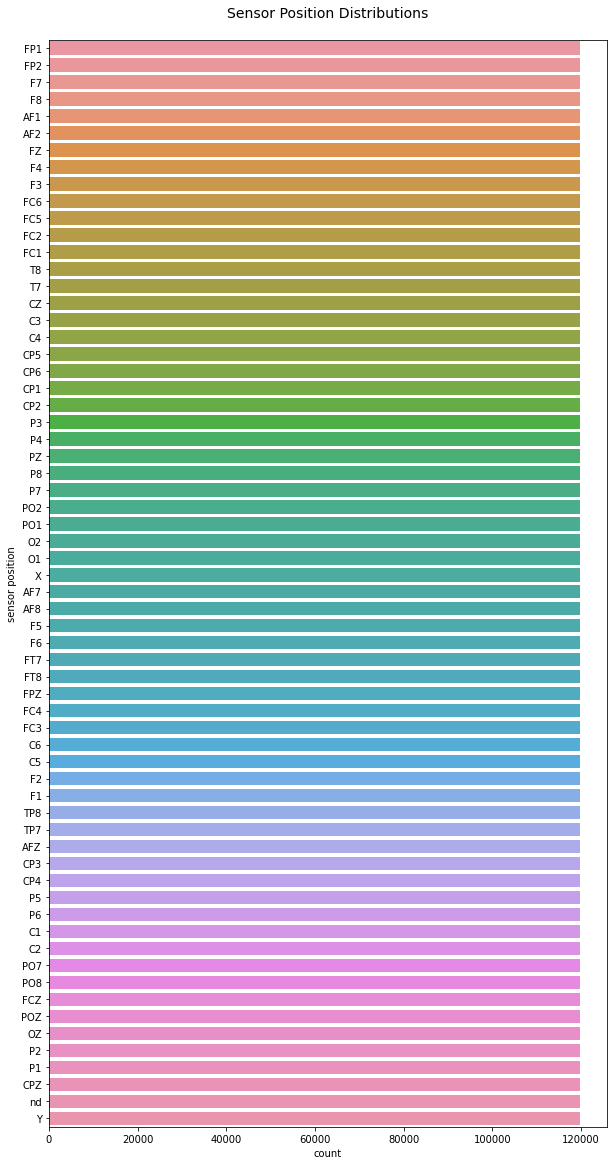

In [ ]:
# Display the class distritution.
plt.figure(figsize=(10,20))
sns.countplot(y='sensor position', data=EEG_data)
plt.title('Sensor Position Distributions\n', fontsize=14)

In [ ]:
# Replace some 'sensor position' values.
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

# Remove rows with undefined positions (X, Y, and nd).
EEG_data = EEG_data[(EEG_data['sensor position'] != 'X') & (EEG_data['sensor position'] != 'Y') & (EEG_data['sensor position'] != 'nd')]

In [ ]:
def sample_data(stimulus, random_id=random.randint(0,7)):
    """Function merged data frame - one data frame for randomly selected subject from control group and 
    one data frame for randomly selected subject from alcoholic group"""
    # Credit: https://github.com/ruslan-kl/EEG-data-analysis/
    ## random choose the name_id of subject from alcoholic/control group
    alcoholic_id = EEG_data['name'][(EEG_data['subject identifier'] == 'a') & 
                                    (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    control_id = EEG_data['name'][(EEG_data['subject identifier'] == 'c') & 
                                  (EEG_data['matching condition'] == stimulus)].unique()[random_id]
    
    ## get min trial numbers for each group
    alcoholic_trial_number = EEG_data['trial number'][(EEG_data['name'] == alcoholic_id) & (EEG_data['matching condition'] == stimulus)].min()
    control_trial_number = EEG_data['trial number'][(EEG_data['name'] == control_id) & (EEG_data['matching condition'] == stimulus)].min()

    ## filter the EEG DF
    alcoholic_df = EEG_data[(EEG_data['name'] == alcoholic_id) & (EEG_data['trial number'] == alcoholic_trial_number)]
    control_df = EEG_data[(EEG_data['name'] == control_id) & (EEG_data['trial number'] == control_trial_number)]
    
    return alcoholic_df.append(control_df)

In [ ]:
sensor_positions = EEG_data[['sensor position', 'channel']].drop_duplicates().reset_index(drop=True).drop(['channel'], axis=1).reset_index(drop=False).rename(columns={'index':'channel'})['sensor position']
channels = EEG_data[['sensor position', 'channel']].drop_duplicates().reset_index(drop=True).drop(['channel'], axis=1).reset_index(drop=False).rename(columns={'index':'channel'})['channel']

def plot_3dSurface_and_heatmap(stimulus, group, df):
    
    if group == 'c':
        group_name = 'Control'
    else:
        group_name = 'Alcoholic'
        
    temp_df = pd.pivot_table(df[['channel', 'sample num', 'sensor value']][(df['subject identifier'] == group) & (df['matching condition'] == stimulus)],
                                          index='channel', columns='sample num', values='sensor value').values.tolist()
    data = [go.Surface(z=temp_df, colorscale='Bluered')]

    layout = go.Layout(
        title='<br>3d Surface and Heatmap of Sensor Values for ' + stimulus + ' Stimulus for ' + group_name + ' Group',
        width=800,
        height=900,
        autosize=False,
        margin=dict(t=0, b=0, l=0, r=0),
        scene=dict(
            xaxis=dict(
                title='Time (sample num)',
                gridcolor='rgb(255, 255, 255)',
    #             erolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            yaxis=dict(
                title='Channel',
                tickvals=channels,
                ticktext=sensor_positions,
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230, 230)'
            ),
            zaxis=dict(
                title='Sensor Value',
                gridcolor='rgb(255, 255, 255)',
                zerolinecolor='rgb(255, 255, 255)',
                showbackground=True,
                backgroundcolor='rgb(230, 230,230)'
            ),
            aspectratio = dict(x=1, y=1, z=0.5),
            aspectmode = 'manual'
        )
    )

    updatemenus=list([
        dict(
            buttons=list([   
                dict(
                    args=['type', 'surface'],
                    label='3D Surface',
                    method='restyle'
                ),
                dict(
                    args=['type', 'heatmap'],
                    label='Heatmap',
                    method='restyle'
                )             
            ]),
            direction = 'left',
            pad = {'r': 10, 't': 10},
            showactive = True,
            type = 'buttons',
            x = 0.1,
            xanchor = 'left',
            y = 1.1,
            yanchor = 'top' 
        ),
    ])

    annotations = list([
        dict(text='Trace type:', x=0, y=1.085, yref='paper', align='left', showarrow=False)
    ])
    layout['updatemenus'] = updatemenus
    layout['annotations'] = annotations

    fig = dict(data=data, layout=layout)
    iplot(fig)

#**Data Sample for 'S1 obj' Stimulus**

In [ ]:
stimulus = 'S1 obj'
S1_sample_df = sample_data(stimulus=stimulus, random_id=7)

In [ ]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S1_sample_df)

In [ ]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S1_sample_df)

#**Data Sample for 'S2 match' Stimulus**

In [ ]:
stimulus = 'S2 match'
S2_m_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [ ]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S2_m_sample_df)

In [ ]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_m_sample_df)

#**Data Sample for 'S2 nomatch' Stimulus**

In [ ]:
stimulus = 'S2 nomatch'
S2_nm_sample_df = sample_data(stimulus=stimulus, random_id=1)

In [ ]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='a', df=S2_nm_sample_df)

In [ ]:
plot_3dSurface_and_heatmap(stimulus=stimulus, group='c', df=S2_nm_sample_df)

#**Correlations between the regions**

In [ ]:
# Create the list of possible channel pairs.
sample_corr_df = pd.pivot_table(S2_nm_sample_df[S2_nm_sample_df['subject identifier'] == 'a'], values='sensor value', index='sample num', columns='sensor position').corr()

list_of_pairs = []
j = 0
for column in sample_corr_df.columns:
    j += 1
    for i in range(j, len(sample_corr_df)):
        if column != sample_corr_df.index[i]:
            temp_pair = [column + '-' + sample_corr_df.index[i]]
            list_of_pairs.append(temp_pair)

In [ ]:
def get_correlated_pairs_sample(threshold, correlation_df, group):
    # Create dictionary wheke keys are the pairs and values are the amount of high correlation pair.
    corr_pairs_dict = {}
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    j = 0
    for column in correlation_df.columns:
        j += 1
        for i in range(j, len(correlation_df)):
            if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    print('Channel pairs that have correlation value >= ' + str(threshold) + ' (' + group + ' group):')
    print(corr_count['channel_pair'][corr_count['count'] > 0].tolist())

In [ ]:
def plot_sensors_correlation(df, threshold_value):
    """Funtion plots the the correlation plots between sensor positions for each group"""
    correlations_alcoholic = pd.pivot_table(df[df['subject identifier'] == 'a'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    correlations_control = pd.pivot_table(df[df['subject identifier'] == 'c'], 
                                          values='sensor value', index='sample num', columns='sensor position').corr()

    fig = plt.figure(figsize=(17,10))
    ax = fig.add_subplot(121)
    ax.set_title('Alcoholic group', fontsize=14)
    mask = np.zeros_like(correlations_alcoholic, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_alcoholic, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    ax = fig.add_subplot(122)
    ax.set_title('Control group', fontsize=14)
    mask = np.zeros_like(correlations_control, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(correlations_control, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.suptitle('Correlation between Sensor Positions for ' + df['matching condition'].unique()[0] + ' stimulus', fontsize=16)
    plt.show()
    
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_alcoholic, group='Alcoholic')
    print('\n')
    get_correlated_pairs_sample(threshold=threshold_value, correlation_df=correlations_control, group='Control')

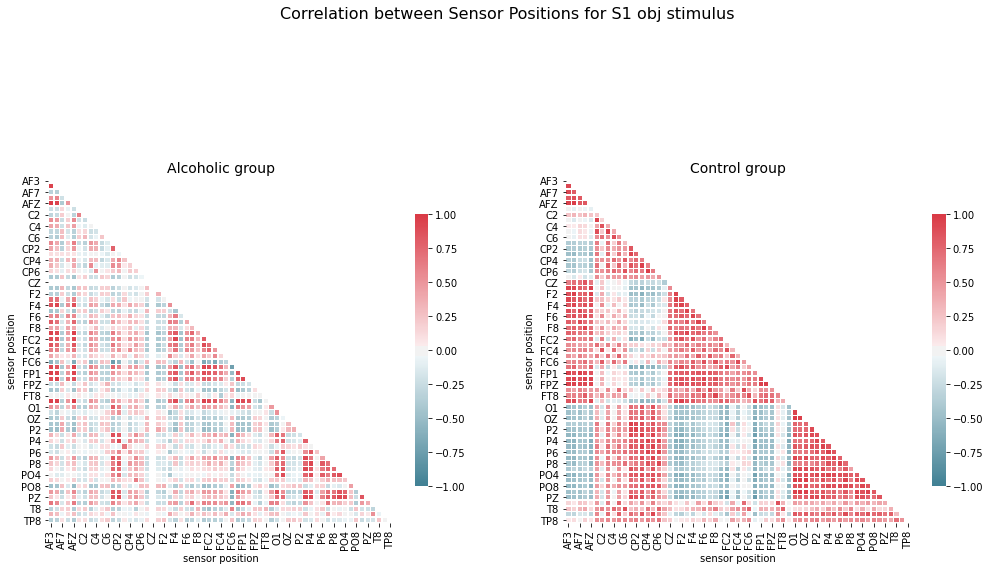

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF3-AFZ', 'AFZ-FZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF4-AFZ', 'CP3-P3', 'CP4-CP6', 'FP2-FPZ', 'O1-OZ', 'O1-PO7', 'O2-OZ', 'OZ-PO7', 'OZ-POZ']


In [ ]:
plot_sensors_correlation(df=S1_sample_df, threshold_value=.97)

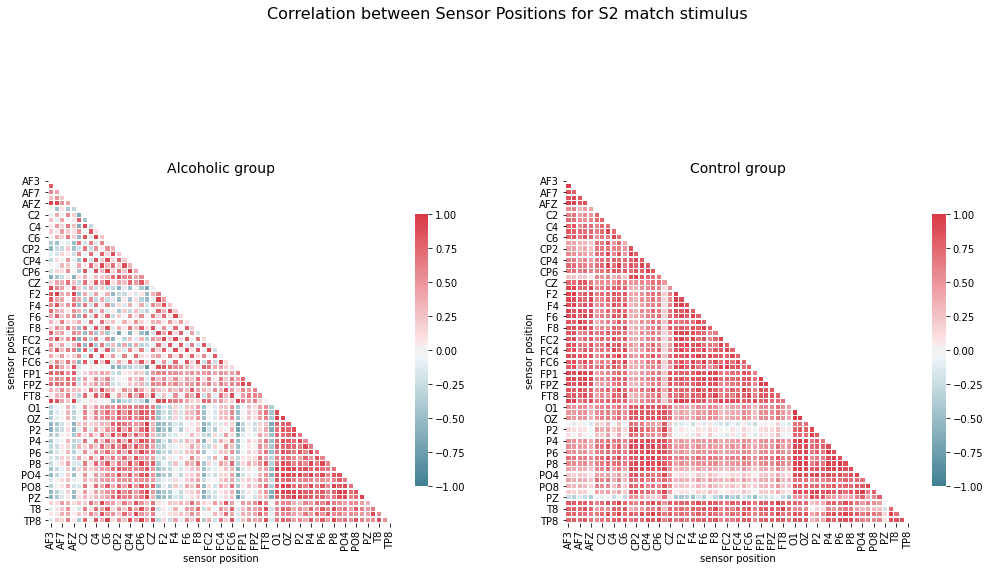

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['AF4-F2', 'CP4-CP6', 'CP6-TP8', 'O1-OZ', 'P1-PZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF4-F2', 'AF8-F8', 'AF8-FP2', 'C5-T7', 'CP3-P5', 'CP5-TP7', 'F1-F3', 'F1-FZ', 'F2-F4', 'F2-FZ', 'FT7-T7', 'O1-O2', 'O1-OZ', 'O2-OZ', 'P4-P6', 'P4-P8', 'P6-P8', 'P7-TP7', 'PO4-POZ']


In [ ]:
plot_sensors_correlation(df=S2_m_sample_df, threshold_value=.97)

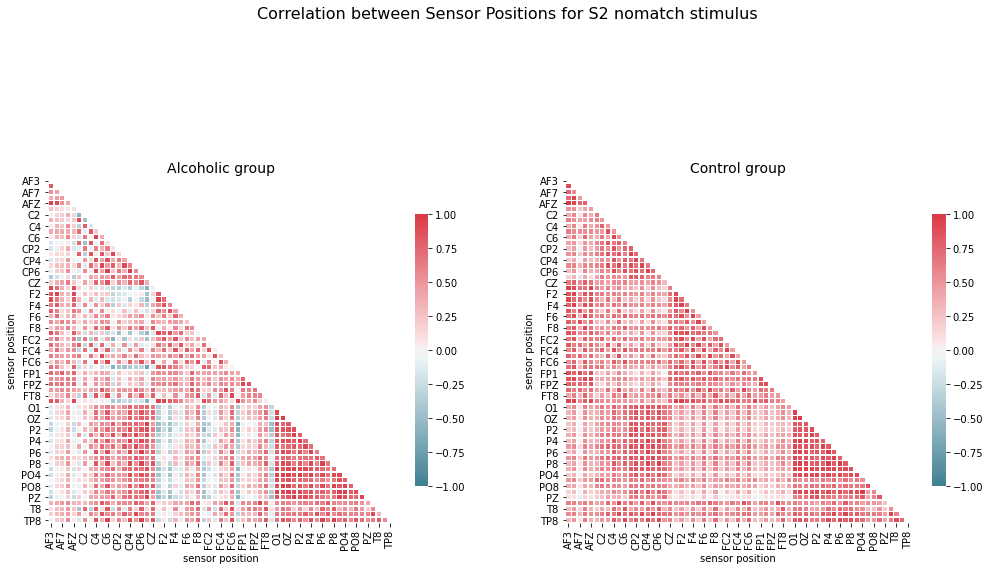

Channel pairs that have correlation value >= 0.97 (Alcoholic group):
['CP6-TP8', 'O1-OZ', 'O2-OZ', 'O2-PO8', 'P1-PZ']


Channel pairs that have correlation value >= 0.97 (Control group):
['AF3-AFZ', 'CP1-CP3', 'O1-OZ', 'O2-OZ', 'P4-P6', 'P4-P8', 'P5-P7', 'P6-P8', 'PO4-POZ']


In [ ]:
plot_sensors_correlation(df=S2_nm_sample_df, threshold_value=.97)

Correlations in F and C regions are higher for Contrl group than Alcoholic group.

In [ ]:
def get_correlated_pairs(stimulus, threshold, group):
    """Funtion returns the df which holds pairs of channel with high correlation for stimulus, group and threshold provided"""
    corr_pairs_dict = {}
    trial_numbers_list = EEG_data['trial number'][(EEG_data['subject identifier'] == group) & (EEG_data['matching condition'] == stimulus)].unique()
    ## create dictionary wheke keys are the pairs and values are the amount of high correlation pair
    for i in range(len(list_of_pairs)):
        temp_corr_pair = dict(zip(list_of_pairs[i], [0]))
        corr_pairs_dict.update(temp_corr_pair)

    for trial_number in trial_numbers_list:    
        correlation_df = pd.pivot_table(EEG_data[(EEG_data['subject identifier'] == group) & (EEG_data['trial number'] == trial_number)], 
                                        values='sensor value', index='sample num', columns='sensor position').corr()

        j = 0 ## by setting the j we are going just through values below the main diagonal
        for column in correlation_df.columns:
            j += 1
            for i in range(j, len(correlation_df)):
                if ((correlation_df[column][i] >= threshold) & (column != correlation_df.index[i])):
                    corr_pairs_dict[column + '-' + correlation_df.index[i]] += 1

    corr_count = pd.DataFrame(corr_pairs_dict, index=['count']).T.reset_index(drop=False).rename(columns={'index': 'channel_pair'})
    corr_count['group'] = group
    corr_count['stimulus'] = stimulus
    return(corr_count)

In [ ]:
def compare_corr_pairs(stimulus):
    """Function creates bar chart with the ratio of correlated pairs for both groups"""
    top_control_df = corr_pairs_df[(corr_pairs_df['group'] == 'c') & (corr_pairs_df['stimulus'] == stimulus)]
    top_alcoholic_df = corr_pairs_df[(corr_pairs_df['group'] == 'a') & (corr_pairs_df['stimulus'] == stimulus)]
    top_control_pairs = top_control_df.sort_values('count', ascending=False)['channel_pair'][:20]
    top_alcoholic_pairs = top_alcoholic_df.sort_values('count', ascending=False)['channel_pair'][:20]

    merged_df = pd.DataFrame({'channel_pair': top_control_pairs.append(top_alcoholic_pairs).unique()})
    merged_df = merged_df.merge(top_control_df[['channel_pair', 'count', 'trials_count']],
                                on='channel_pair', how='left').rename(columns={'count':'count_control', 'trials_count': 'trials_count_c'})
    merged_df = merged_df.merge(top_alcoholic_df[['channel_pair', 'count', 'trials_count']],
                                on='channel_pair', how='left').rename(columns={'count':'count_alcoholic', 'trials_count': 'trials_count_a'})

    data_1 = go.Bar(x=merged_df['channel_pair'],
                    y=(merged_df['count_alcoholic']/merged_df['trials_count_a']).apply(lambda x: round(x,2)),
                    text=merged_df['count_alcoholic'],
                    name='Alcoholic Group',
                    marker=dict(color='rgb(20,140,45)'))

    data_2 = go.Bar(x=merged_df['channel_pair'],
                    y=(merged_df['count_control']/merged_df['trials_count_c']).apply(lambda x: round(x,2)),
                    text=merged_df['count_control'],
                    name='Control Group',
                    marker=dict(color='rgb(200,100,45)'))

    layout = go.Layout(title='Amount of Correlated Pairs for the whole Data Set (' + stimulus + ' stimulus)',
                       xaxis=dict(title='Channel Pairs'),
                       yaxis=dict(title='Ratio'),
                       barmode='group')

    data = [data_1, data_2]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [ ]:
corr_pairs_df = pd.DataFrame({})
stimuli_list = ['S1 obj', 'S2 match', 'S2 nomatch']
# Create df that holds information of total trial amount for each subject by stimulus.
size_df = EEG_data.groupby(['subject identifier', 'matching condition'])[['trial number']].nunique().reset_index(drop=False).rename(columns={'trial number':'trials_count'})

for stimulus in stimuli_list:
    corr_pairs_df = corr_pairs_df.append(get_correlated_pairs(stimulus=stimulus, threshold=.9, group='c'))
    corr_pairs_df = corr_pairs_df.append(get_correlated_pairs(stimulus=stimulus, threshold=.9, group='a'))
corr_pairs_df = corr_pairs_df.merge(size_df, left_on=['group', 'stimulus'], right_on=['subject identifier', 'matching condition'], how='left')

In [ ]:
compare_corr_pairs(stimulus='S1 obj')

In [ ]:
compare_corr_pairs(stimulus='S2 match')

In [ ]:
compare_corr_pairs(stimulus='S2 nomatch')

FP1-FPZ and FP1-FP2 pairs showed the high correlation value for control subjects >90% of the time. But for the alcoholic group this ration is much lower (~20%).

In [ ]:
stimulus_list = EEG_data['matching condition'].unique().tolist() # list of stimuli
channels_list = EEG_data['channel'].unique().tolist() # list of channels

# Get the Average Sensor Values for each channel by Subject group and Stimulus.
agg_df = EEG_data.groupby(['subject identifier', 'matching condition', 'sensor position'], as_index=False)[['sensor value']].mean()

In [ ]:
def get_p_value(stimulus, sensor):
    """
    Funtion takes the stimulus parameter and channel number and returns the p-value from Mann Whitney U-test (Alcoholic vs Control).
    """
    x = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'a') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    y = EEG_data[['sensor value']][(EEG_data['subject identifier'] == 'c') & 
                                   (EEG_data['matching condition'] == stimulus) & 
                                   (EEG_data['sensor position'] == sensor)]
    stat, p = mannwhitneyu(x=x, 
                           y=y,
                           alternative='two-sided')
    return p

In [ ]:
# Create empty df that will hold info about the statistica test.
stat_test_results = pd.DataFrame({'stimulus': [], 
                                  'sensor': [],
                                  'p_value': []})

for sensor in tqdm(EEG_data['sensor position'].unique()):
    for stimulus in EEG_data['matching condition'].unique():
        temp_df = pd.DataFrame({'stimulus': stimulus,
                                'sensor': sensor,
                                'p_value': get_p_value(stimulus=stimulus, sensor=sensor)},
                               index=[0])
        stat_test_results = stat_test_results.append(temp_df)
        
stat_test_results = stat_test_results.reset_index(drop=True)
stat_test_results['reject_null'] = stat_test_results['p_value'] <= 0.05 # check whether we can reject null hypothesis

100%|██████████| 61/61 [07:24<00:00,  7.29s/it]


In [ ]:
stat_test_results.groupby(['stimulus'])[['reject_null']].mean()

,reject_null
stimulus,
S1 obj,0.901639
S2 match,0.770492
S2 nomatch,0.803279


Approximately 90% of channels (\~55 channels) responed significanlty different when single object was shown.<br>
Approximately 77% of channels (\~47 channels) responed significanlty different when two identical objects were shown.<br>
Approximately 80% of channels (\~50 channels) responed significanlty different when two non-identical objects were shown.

In [ ]:
data = []
for stimulus in stimulus_list:
    trace = go.Bar(x=stat_test_results['sensor'][stat_test_results['stimulus'] == stimulus],
                    y=stat_test_results['reject_null'][stat_test_results['stimulus'] == stimulus],
                    name=stimulus)
    data.append(trace)

layout = go.Layout(title='Amount of Significant Differences for each Channel',
                   xaxis=dict(title='Sensor Position'),
                   yaxis=dict(title='Is Significant',
                   showticklabels=False),
                   barmode='stack')
fig = go.Figure(data=data, layout=layout)
iplot(fig)